# [Exp14] Korean Chatbot

## 라이브러리 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Step 1. 데이터 불러오기

* 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.
* [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

In [2]:
data_path = 'data/ChatbotData.csv'
data = pd.read_csv(data_path)
origin_data = data.copy()

* 데이터를 살펴봅시다.
* head, tail 을 이용해 앞 부분과 뒷부분을 살펴봅니다.

In [3]:
data.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [4]:
data.tail(10)

,Q,A,label
11813,회사에 좋아하는 남자가 생겼어 어떡하지?,사랑하기 힘든 관계인가봐요.,2
11814,회사에서 어떤 사람이랑 자꾸 눈 마추쳐.,눈 마주치는 게 우연인지 잘 살펴 보세요.,2
11815,회식 중이라고 하는데 연락이 안돼.,정신 없이 바쁠지도 몰라요. 조금만 더 기다려보고 물어보는게 좋을 것 같아요.,2
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.,2
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.,2
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


In [5]:
data.shape

(11823, 3)

* 11823개의 데이터가 있으며 col은 질문, 답변, label로 되어있습니다.

In [6]:
data.Q.describe()

count     11823
unique    11662
top         외로워
freq          4
Name: Q, dtype: object

In [7]:
data.A.describe()

count        11823
unique        7779
top       맛있게 드세요.
freq            22
Name: A, dtype: object

In [8]:
print(data.label.describe())
print(set(data.label))

count    11823.000000
mean         0.803180
std          0.812012
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: label, dtype: float64
{0, 1, 2}


* Q(질문), A(답변)은 str 값, label은 float 값으로 되어있습니다.
* 각각의 질문과 답변에 대해 중복되는 값들이 있음이 확인되었습니다.
* label은 일상다반사 = 0, 이별(부정) = 1, 사랑(긍정) = 2로 되어있습니다.

## Step 2. 데이터 전처리하기

### 기본 전처리

* 일단 사용하지 않을 label 열을 제거하겠습니다.

In [9]:
data.drop('label', axis = 1, inplace= True)
display(data.head(1))
display(data.tail(1))

,Q,A
0,12시 땡!,하루가 또 가네요.


,Q,A
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.


* NULL 값 확인

In [10]:
data.isna().sum()

Q    0
A    0
dtype: int64

* NULL 값은 없습니다.

기본 계획
* 일단 11823개 전부 사용
* 정규표현식을 사용
* 구두점 제거?
* 숫자 및 영얼 처리?
* 준말 또는 띄어쓰기 처리?

### 전처리 전 탐색

데이터를 직접 살펴보면서 추가할 전처리 내용을 알아보겠습니다.


In [11]:
pd.set_option('display.max_row', None)

#### 구두점

* 구두점 중에서 ! ? . , 을 제외한 것을 가지는 문장들을 출력해보겠습니다.
* 정규표현식에서 한글은 '가-힣ㄱ-ㅎㅏ-ㅣ'로 구분합니다.

In [12]:
data_punc = data[(data.Q.str.contains(r'[^a-zA-Z0-9가-힣ㄱ-ㅎㅏ-ㅣ!?., ]') == True) | (data.A.str.contains(r'[^a-zA-Z0-9가-힣ㄱ-ㅎㅏ-ㅣ!?., ]') == True)]
print(len(data_punc))
display(data_punc)

57


,Q,A
100,거지됐어,밥 사줄 친구를 찾아 보세요~
468,나 그지임,밥 사줄 친구를 찾아 보세요~
592,나는 좋은데 ….,현실의 벽에 부딪혔나봐요.
701,날씨가 진짜 덥다,시원한 물이라도 한 잔 드세요~
954,너무 더워,시원한 물이라도 한 잔 드세요~
1300,돈 어디갔지,퍼가요~
1313,돈이 엄떠,퍼가요~
1398,떠나요~ 제주도~,여행 좋죠!
1902,바람쐬러 정동진가~~,잘 놀다 오세요.
1932,반지 호수 모르는데,음~ 곰곰히 생각해보세요.


구두점 처리
* ... .... ~ ~~~~ ; ' % 등이 있습니다.
* %는 15% 배터리 15%로 구두점 자체가 큰 의미가 있어 보입니다.
* 즉 15%를 한단어로 인식해야 합니다. 나머지는 제거 해주어도 무방할 것 같습니다.

#### 영어

In [13]:
data_contain_eng = data[(data.Q.str.contains(r'[a-zA-Z]') == True) | (data.A.str.contains(r'[a-zA-Z]') == True)]
print(len(data_contain_eng))
display(data_contain_eng)

42


,Q,A
4,PPL 심하네,눈살이 찌푸려지죠.
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.
10,SNS보면 나만 빼고 다 행복해보여,자랑하는 자리니까요.
754,남친 SNS에 내 사진 없어,신경쓰지 마세요.
762,남친이 SNS에 내 사진에 안 올려,신경쓰지 마세요.
1401,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.


영어 처리
* PPL : 냅두기
* SD카드 : SD제거 -> 카드
* jk김동욱 : jk제거 -> 김동욱
* SNS,sns : sns -> SNS , SNS + 양쪽 ' ' (공백추가)
* cc,CC : CC + ' '(공백추가) 
* AS, as : AS, as -> 수리
* gogo : gogo -> 가세요

#### 숫자

* 이번엔 숫자가 포함된 행을 개수를 세어봅시다.


In [14]:
data_contain_num = data[(data.Q.str.contains(r'[0-9]') == True) | (data.A.str.contains(r'[0-9]') == True)]
len(data_contain_num)
display(data_contain_num)

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
67,강렬한 첫인상 남겨야 하는데,처음 3초가 중요해요. 당신의 매력을 어필해보세요.
176,고3은 공부만 해야겠지.,공부가 최우선이죠.
177,고3이니까 공부해야겠지,공부가 최우선이죠.
546,나 정신차리게 말해줘,나 자신에 집중하세요. 언제나 1순위에 자신을 두세요.
1150,단거 땡긴다.,맛있게 먹으면 0칼로리!
1163,달달한 거 먹고 싶다.,맛있게 먹으면 0칼로리!


숫자 처리
* 숫자 + 시간, 숫자 + 단어가 많았습니다.
* 그리고 해당 숫자 다음에 띄어쓰기가 제대로 되지 않은 문제들이 많았습니다.
* (숫자+시간, 숫자+단어) 양쪽에 ' ' 을 추가하겠습니다.(공백 추가)

시간
* 년
* 월, 개월, 달
* 주, 일
* 시, 분, 초

단위
* 지망, 순위, 위, 호, 번, 살

### 함수 설정

In [15]:
def preprocess_sentence(sentence):
    # 영어 대문자로 바꿔준 뒤, 혹시 있을지 모를 좌우 공백 제거
    sentence = sentence.upper().strip()
    
    # 구두점 처리
    # 단어와 구두점 사이의 거리를 만듭니다.(알파벳,한글,숫자,%를 제외한 전부)
    sentence = re.sub(r"([^a-zA-Z0-9가-힣ㄱ-ㅎㅏ-ㅣ% ])", r" \1 ", sentence)
    # %의 경우 뒤에만 공백을 추가합니다.
    sentence = re.sub(r"(%)", r"\1 ", sentence)
    # 공백이 여러 개인 경우 하나로 만들어줍니다.
    sentence = re.sub(r'[" "]+', " ", sentence)
    # (한글, 알파벳, 숫자, ".", "?", "!", ",", "%")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z0-9가-힣ㄱ-ㅎㅏ-ㅣ.?!,%]+", " ", sentence)
    
    # 영어 처리
    # SD, JK 제거
    sentence = re.sub("SD", " ", sentence)
    sentence = re.sub("JK", " ", sentence)
    # SNS + " ", CC + " "
    sentence = re.sub("SNS", " SNS ", sentence)
    sentence = re.sub("CC", " CC ", sentence)
    # AS - 수리, gogo - 가세요
    sentence = re.sub("AS", "수리", sentence)
    sentence = re.sub("gogo", "가세요", sentence)
    
    # 숫자 처리
    # 단어 변경
    sentence = re.sub(r"주년", r"년", sentence)
    sentence = re.sub(r"주일", r"주", sentence)
    # 시간
    sentence = re.sub(r"([0-9]+년)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+월)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+개월)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+달)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+일)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+주)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+시)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+분)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+초)", r" \1 ", sentence)
    # 단위
    sentence = re.sub(r"([0-9]+순위)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+위)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+호)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+번)", r" \1 ", sentence)
    sentence = re.sub(r"([0-9]+살)", r" \1 ", sentence)
    
    # 맞춤법, 동의어 또는 띄어쓰기 개별 추가
    sentence = re.sub("고3", "고3 ", sentence)
    sentence = re.sub("긴", "긴 ", sentence)
    sentence = re.sub("너무", "너무 ", sentence)
    sentence = re.sub("중2", "중2병", sentence)
    sentence = re.sub("제 2 외국어", "제2외국어", sentence)
    sentence = re.sub("남친", "남자친구", sentence)
    sentence = re.sub("남자친구이", "남자친구가", sentence)
    sentence = re.sub("남자친구과", "남자친구와", sentence)
    sentence = re.sub("여친", "여자친구", sentence)
    sentence = re.sub("여자친구이", "여자친구가", sentence)
    sentence = re.sub("여자친구과", "여자친구와", sentence)
    sentence = re.sub("핸드폰", "휴대폰", sentence)
    sentence = re.sub("연예", "연애", sentence)
    sentence = re.sub("연애인", "연예인", sentence)
    
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    
    return sentence

### 적용 및 확인

#### 구두점

In [16]:
data_copy = data.copy()
questions = []
answers = []
for q in data_copy.Q:
    s1 = preprocess_sentence(q)
    questions.append(s1)

for a in data_copy.A:
    s2 = preprocess_sentence(a)
    answers.append(s2)

* %가 제대로 나오는지 확인

In [17]:
for x in questions:
    if '%' in x:
        print(x)
for y in answers:
    if '%' in y:
        print(y)

베터리 15% 야
베터리 겨우 15% 야


#### 영어

In [18]:
for x in questions:
    if '카드' in x or '김동욱' in x:
        print(x)
for y in answers:
    if '카드' in y or '김동욱' in y:
        print(y)

카드 망가졌어
카드 안돼
메모리카드 어디다 두었을까
메모리카드 잃어버렸어
술 먹고 카드 긁었어
술 먹고 카드 너무 긁었어
신용카드 다 없애야겠어
이 놈의 신용카드 다 없애야지
카드 다 부러뜨려 버려야겠다 .
카드 다 없애버려야지
카드가 못찾겠다 .
카드가 왜 없지
카드값 갚느라 허리가 휘어
카드값 너무 많이 나왔어 .
김동욱 노래 생각나네


In [19]:
for x in questions:
    if 'SNS' in x or 'CC' in x:
        print(x)
for y in answers:
    if 'SNS' in y or 'CC' in y:
        print(y)

SNS 맞팔 왜 안하지ㅠㅠ
SNS 시간낭비인 거 아는데 매일 하는 중
SNS 시간낭비인데 자꾸 보게됨
SNS 보면 나만 빼고 다 행복해보여
남자친구 SNS 에 내 사진 없어
남자친구가 SNS 에 내 사진에 안 올려
SNS 를 끊어야 하는데 .
SNS 흔적
SNS 에서 다른 이성이랑 대화하는걸 보니 화가 나
그녀에 SNS 를 봤습니다 .
몰래 SNS 훔쳐보고 있는 나 한심해
오늘 또 헤어진 사람의 SNS 를 봤네
오늘도 전 여자친구 SNS 를 봤습니다
헤어진 남자친구의 SNS 행적
CC 레알 별로임 ?
같은 과에 내 이상형인 남자애가 있는데 CC 는 무리일까 ?
남자친구가 SNS 에 나 안 올려 .
여자친구가 나를 SNS 에 올리지 않아서 서운해 .
여자친구의 SNS 말투가 고민이야 .
좋아하는 사람 생기면 어떻게든 SNS 같은 거 알아내서 친신하고 그래 ?
SNS 끊는게 힘들죠 .
SNS 흔적 삭제하세요 .
SNS 보지 마세요 .
SNS 는 보지 않는 게 좋겠어요 .
SNS 검색하지 마세요 .
SNS 를 삭제하는게 어떨까요 . 미련만 남을 뿐이에요 .
SNS 를 삭제하는게 어떨까요 . 미련만 남을 뿐이에요 .
SNS 끊으세요 .
CC 는 아무래도 제약이 있을 거예요 .
SNS 에 올리는 걸 안 좋아하는 사람도 있어요 .


In [20]:
for x in questions:
    if '수리' in x or 'gogo' in x:
        print(x)
for y in answers:
    if '수리' in y or 'gogo' in y:
        print(y)

정수리 냄새
정수리 냄새 난 거 아니야 ?
수리 맡기세요 .
수리 맡기세요 .
수리센터에 맡겨보세요 .
수리센터에 맡겨보세요 .
수리센터에 맡겨보세요 .
수리 맡기세요 .
수리센터에 맡겨보세요 .
수리 맡기세요 .


#### 숫자

In [21]:
number = ['0','1','2','3','4','5','6','7','8','9',]
for x in questions:
    for n in number:
        if n in x:
            print(x)
for x in answers:
    for n in number:
        if n in y:
            print(y)

12시 땡 !
12시 땡 !
1지망 학교 떨어졌어
3박 4일 놀러가고 싶다
3박 4일 놀러가고 싶다
3박 4일 정도 놀러가고 싶다
3박 4일 정도 놀러가고 싶다
고3 은 공부만 해야겠지 .
고3 이니까 공부해야겠지
밤 12시 야
밤 12시 야
베터리 15% 야
베터리 15% 야
베터리 겨우 15% 야
베터리 겨우 15% 야
쓸데 없는 걱정 1위 연예인 걱정
원서 낸거 1지망에서 떨어졌어
제2외국어 뭐할까
제2외국어 뭐 선택할까
중2병 아들 때매 고민이야
중2병 히스테리 알아 ?
중2병병
중2병병 이라더니 진짜 속썩일 줄이야
중2병병인거 같아
통장잔고가 0이야
1000일 만난 여자친구와 이별
1000일 만난 여자친구와 이별
10년 연애 . 헤어졌습니다 .
10년 연애 . 헤어졌습니다 .
10년 연애사 되돌아보니 다 부질없네
10년 연애사 되돌아보니 다 부질없네
10년 연애의끝
10년 연애의끝
10년 만나다 헤어지네
10년 만나다 헤어지네
10년 이라는 시간이 참 무색하다 싶네
10년 이라는 시간이 참 무색하다 싶네
10월 의 마지막밤 . 더 보고싶네 그사람
10월 의 마지막밤 . 더 보고싶네 그사람
14년 된 여자친구랑 이별
14년 된 여자친구랑 이별
14년 의 기나긴 이야기 .
14년 의 기나긴 이야기 .
15년 안녕
15년 안녕
15년 만에 쓰는 편지 .
15년 만에 쓰는 편지 .
1년 9개월 의 연애 종지부 .
1년 9개월 의 연애 종지부 .
1년 반 .
1년 4개월 의 종지부를 찍네 .
1년 4개월 의 종지부를 찍네 .
1년 동거 끝에 헤어짐
1년 만에 꿈에나와서 설레게하네
1년 만에 다시헤어지게 됐네
1년 만의 연애가 끝났네
1년 을 넘게 만났는데 어떻게 이럽니까
1년 이 되어갑니다
1년 이 아무것도 아니였나
1년 이 지났어도
1년 전 그 날
1년 전 헤어진 남자한테서 연락이 왔어
2년 6개월 이렇게 끝나네
2년 6개월 이렇게 끝나네
2년 가까이 여자친구하구 헤어졌습니다
2년 가량의 연애
2년 다되가는 연애 끝 .
2년 만에 연락 그후입니다 .
2년 사

#### 개수 확인

* 혹시 모를 NULL 확인

In [22]:
for sentence in questions:
    if sentence == "" or sentence == " ":
        print("void input!!")
for sentence in answers:
    if sentence == "" or sentence == " ":
        print("void output!!")


* NULL은 없습니다.
* 다시 한번 개수를 확인해보겠습니다.

In [23]:
print(len(questions), len(answers))

11823 11823


* 개수 도한 11823개가 맞습니다.
* 랜덤으로 출력해보겠습니다.

In [24]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[9423]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[9423]))

전처리 후의 22번째 질문 샘플: 남자친구가 나를 좋아하는게 맞겠지 ?
전처리 후의 22번째 답변 샘플: 그렇게 생각하는게 도움이 될 때가 있지요 .


### 문장 길이 분석

In [25]:
lenQ = []
lenA = []
for q in questions:
    lenQ.append(len(q))
for a in answers:
    lenA.append(len(a))

In [26]:
print("질문 길이 평균 :", sum(lenQ)/len(lenQ))
print("대답 길이 평균 :", sum(lenA)/len(lenA))
print("질문 길이 최대/최소 :" , max(lenQ), min(lenQ))
print("대답 길이 최대/최소 :" , max(lenA), min(lenA))
print("최대 길이 질문 :", questions[lenQ.index(max(lenQ))])
print("최대 길이 대답 :", answers[lenA.index(max(lenA))])

질문 길이 평균 : 13.287152161042037
대답 길이 평균 : 16.039922185570497
질문 길이 최대/최소 : 57 1
대답 길이 최대/최소 : 78 1
최대 길이 질문 : 확실히 좋아하는 데도 관심 있는거 티 안내려고 선톡 안하고 일부러 늦게 보내고 그러는 사람도 있어요 ?
최대 길이 대답 : 연애는 문제가 있으면 문제를 해결 하기 위해 함께 노력하고 그 속에서 더욱 단단해지는 과정인데 , 그 과정을 못 참고 피하기만 했나봅니다 .


* 단순히 평균과 최대/최소만으로 문장 길이 분포를 알기는 어렵네요.
* 그래프로 그려봅시다.

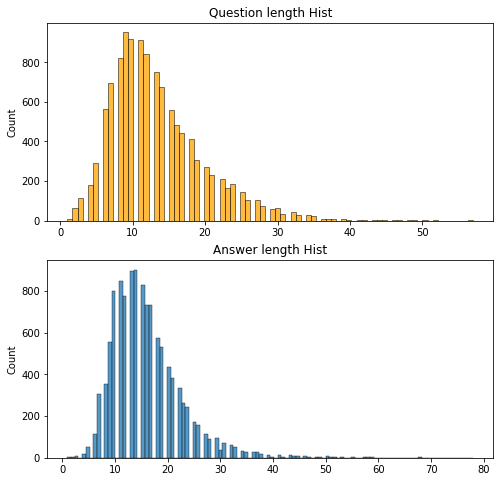

In [27]:
fig, axes = plt.subplots(2, figsize = (8,8))
axes[0].set_title("Question length Hist")
sns.histplot(lenQ , ax = axes[0], color = 'orange')
axes[1].set_title("Answer length Hist")
sns.histplot(lenA , ax = axes[1])
plt.show()

* 약 28정도로 잡고 비율을 알아봅시다.

In [28]:
MAX_LENGTH = 28
Qnum = 0
Anum = 0
for q in lenQ:
    if q <= MAX_LENGTH:
        Qnum += 1
for a in lenA:
    if a <= MAX_LENGTH:
        Anum += 1

print("제거 후 질문 수, 제거 후 답변 수:", Qnum,',', Anum)
print("질문 비율 :", Qnum/len(lenQ) * 100)
print("대답 비율 :", Anum/len(lenA) * 100)

제거 후 질문 수, 제거 후 답변 수: 11483 , 11246
질문 비율 : 97.12424934449801
대답 비율 : 95.11968197580987


* 나쁘지 않은 비율입니다.
* 28 길이가 넘는 경우에는 데이터에서 제외하도록 합시다.

In [29]:
newQ, newA = [],[]

for (sentence1, sentence2) in zip(questions, answers):
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
        newQ.append(sentence1)
        newA.append(sentence2)

print('원본 질문과 답변의 크기:',len(questions), len(answers))
print('제거해준 질문과 답변의 크기:',len(newQ), len(newA))
print('원본과의 비율:', len(newQ)/len(questions)*100)

원본 질문과 답변의 크기: 11823 11823
제거해준 질문과 답변의 크기: 10941 10941
원본과의 비율: 92.53996447602132


* 다시 한번 길이 분포 확인하기

In [30]:
len_newQ = []
len_newA = []
for q in newQ:
    len_newQ.append(len(q))
for a in newA:
    len_newA.append(len(a))

* 그래프로 출력해서 알아봅시다.

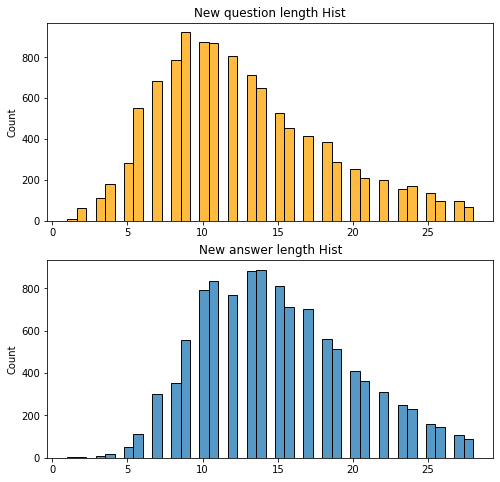

In [31]:
fig, axes = plt.subplots(2, figsize = (8,8))
axes[0].set_title("New question length Hist")
sns.histplot(len_newQ , ax = axes[0], color = 'orange')
axes[1].set_title("New answer length Hist")
sns.histplot(len_newA , ax = axes[1])
plt.show()

* 나쁘지 않습니다. 변수명을 바꾸어 준 뒤 다음 단계로 넘어가겠습니다.

In [32]:
questions = newQ
answers = newA

In [33]:
len(questions)

10941

## SubwordTextEncoder 사용하기

### 단어장을 만듭니다.

In [34]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

* 단어장의 크기는 기존 단어장에서 START_TOKEN과 END_TOKEN을 합친 크기가 됩니다.

In [35]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print("추가된 단어장의 크기:", VOCAB_SIZE)

START_TOKEN의 번호 : [7476]
END_TOKEN의 번호 : [7477]
추가된 단어장의 크기: 7478


### 정수 인코딩 과정

In [36]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5211, 555, 2575, 3737]
정수 인코딩 후의 21번째 답변 샘플: [2772, 6849, 10, 5688, 94, 1]


* 원래 28자까지 였으나 start와 end가 추가되므로 30이 최종 길이 입니다.

In [37]:
MAX_LENGTH = 30
print(MAX_LENGTH)

30


In [38]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 30 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    # tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
    # tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='pre')
    
    return tokenized_inputs, tokenized_outputs

* pre로 한 경우 loss와 accuracy는 눈에 띄게 좋아지지만 챗 봇 단계에서 예측 문장이 너무 불필요한 단어를 반복하였습니다.
* post로 하도록 하겠습니다.

In [39]:
print('필터링 전 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 전 답변 샘플 개수: {}'.format(len(answers)))
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

필터링 전 질문 샘플 개수: 10941
필터링 전 답변 샘플 개수: 10941
단어장의 크기 : 7478
필터링 후의 질문 샘플 개수: 10941
필터링 후의 답변 샘플 개수: 10941


* 이미 긴 문장은 처리해줬으므로 당연히 샘플 개수는 변화가 없습니다.

In [40]:
questions

array([[7476, 7215, 2322, ...,    0,    0,    0],
       [7476, 7269,   43, ...,    0,    0,    0],
       [7476, 7271, 3184, ...,    0,    0,    0],
       ...,
       [7476, 7457, 7377, ...,    0,    0,    0],
       [7476,  135,  197, ...,    0,    0,    0],
       [7476, 1934,  707, ...,    0,    0,    0]], dtype=int32)

In [41]:
answers

array([[7476, 3448,   67, ...,    0,    0,    0],
       [7476, 1795, 4956, ...,    0,    0,    0],
       [7476, 3681,  817, ...,    0,    0,    0],
       ...,
       [7476, 6273,  294, ...,    0,    0,    0],
       [7476,   12, 4199, ...,    0,    0,    0],
       [7476,  231,  460, ...,    0,    0,    0]], dtype=int32)

* 알맞게 정수로 인코딩 되었습니다.

### Teache Forcing 적용

In [42]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

2022-09-13 17:27:23.174544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 17:27:23.617211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


## Step 4. 모델 구성하기

* 트랜스포머 모델을 구성하기 위해 하나씩 다시 만들어봅시다.
* Encoder, Decoder의 Layer에 들어가는 함수들을 만들어주고
* Encoder, Decoder layer 와 다른 함수들로 Encoder, Decoder를 만들고
* Encdoer, Decoder 로 Transformer 모델을 만듭니다.

### Encoder, Decoder를 위한 함수

#### Positional encoding

In [43]:
# keras의 layer를 입력으로 받는 class 포지셔널 행렬 생성
class PositionalEncoding(tf.keras.layers.Layer):

  # 초기화 함수(self, 임베딩 벡터의 위치, 임베딩 벡터의 차원)
  def __init__(self, position, d_model):
    # 원래 positional encoding의 init을 상속받기
    super(PositionalEncoding, self).__init__()
    # positional encoding 함수 자체(본인)
    self.pos_encoding = self.positional_encoding(position, d_model)

  # 각도 구하기(self, 임베딩 벡터의 위치, 임베딩 벡터내 차원의 index, 임베딩 벡터의 차원)
  def get_angles(self, position, i, d_model):
    # 위 공식에서 pos 뒤 / 부분
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    # pos를 곱해준다, 곱해준 값을 가지고 sin과 cos를 구함.
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#### Scaled dot product attention

In [44]:
def scaled_dot_product_attention(query, key, value, mask):
  # 곱하기 전에 2번째 값(b)를 전치한다.
  matmul_qk = tf.matmul(query, key, transpose_b=True)
  
  # 정규화를 위해 구하느 깊이 값
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  # 깊이 값을 제곱근을 나눠줌으로써 정규화
  logits = matmul_qk / tf.math.sqrt(depth)
  
  if mask is not None:
    logits += (mask * -1e9)
  
  attention_weights = tf.nn.softmax(logits, axis=-1)
  
  output = tf.matmul(attention_weights, value)
  return output

#### Multihead attention

In [45]:
# 멀티 헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
  # 초기화
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    # 기존의 MultiHeadAttention의 init을 상속합니다.
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model
    
    # 해당 조건을 경우에 제대로 돌아간다고 가정(딱 나눠서 떨어지는게 맞지..)
    assert d_model % self.num_heads == 0
    
    # 나눗셈(나머지를 버린다. 어차피 위의 조건에 0이니까 그냥 나누기 int랑 같을 듯)
    self.depth = d_model // self.num_heads
    
    # 각각의 FCN layer를 선언
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)
    
    self.dense = tf.keras.layers.Dense(units=d_model)
    
  # 머리 수에 맞게 쪼개줌
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])
  
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]
    
    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)
    
    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)
    
    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    
    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))
    
    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)
    
    return outputs

#### Padding mask

In [46]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

#### Look-ahead masking

In [47]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # print('seq_len :', seq_len)
    # seq_len 크기를 가지는 1로만 이루어진 행렬을 가지고 하 삼각행렬을 만듭니다.
    # 그 값을 1에서 빼줍니다
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    # print("look_ahead_mask")
    # print(look_ahead_mask)
    # x에 패딩 마스크
    padding_mask = create_padding_mask(x)
    # print("padding_mask")
    # print(padding_mask)
    # 2개 중 큰 값을 리턴
    return tf.maximum(look_ahead_mask, padding_mask)

### Encoder

#### Encoder Layer

In [48]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
            })
        
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### Encoder

In [49]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder

#### Decoder Layer

In [50]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # Masksed Multi head Attention 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

#### Decoder

In [51]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### Transformer

In [52]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### Model Generate

#### Model

In [53]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    13296640    ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

#### Loss function

In [54]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

#### Custom scheduling

In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Model Compile and train

#### Model Compile

In [56]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### Train

In [57]:
EPOCHS = 15
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/15
171/171 [==============================] - 36s 131ms/step - loss: 1.7101 - accuracy: 0.0302
Epoch 2/15
171/171 [==============================] - 23s 132ms/step - loss: 1.3751 - accuracy: 0.0623
Epoch 3/15
171/171 [==============================] - 23s 132ms/step - loss: 1.2424 - accuracy: 0.0680
Epoch 4/15
171/171 [==============================] - 23s 133ms/step - loss: 1.1877 - accuracy: 0.0701
Epoch 5/15
171/171 [==============================] - 23s 133ms/step - loss: 1.1512 - accuracy: 0.0723
Epoch 6/15
171/171 [==============================] - 23s 133ms/step - loss: 1.1116 - accuracy: 0.0744
Epoch 7/15
171/171 [==============================] - 23s 133ms/step - loss: 1.0619 - accuracy: 0.0776
Epoch 8/15
171/171 [==============================] - 23s 133ms/step - loss: 1.0040 - accuracy: 0.0813
Epoch 9/15
171/171 [==============================] - 23s 133ms/step - loss: 0.9351 - accuracy: 0.0863
Epoch 10/15
171/171 [==============================] - 23s 133ms/step - l

* loss도 줄어들고 accuray도 증가했습니다.

## Step 5. 모델 평가하기

### inference 함수 설정

In [58]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

### Chatbot

In [59]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [60]:
sentence_generation('이별 . 정말로 힘드네 .')

입력 : 이별 . 정말로 힘드네 .
출력 : 또 다른 시작을 정리하세요 .


'또 다른 시작을 정리하세요 .'

In [61]:
sentence_generation('전 여자친구 보고싶어 .')

입력 : 전 여자친구 보고싶어 .
출력 : 이제 남이에요 .


'이제 남이에요 .'

In [62]:
sentence_generation('7년 전 이 날 헤어졌어 .')

입력 : 7년 전 이 날 헤어졌어 .
출력 : 이제 미련이 남지 나봅니다 .


'이제 미련이 남지 나봅니다 .'

In [63]:
sentence_generation('오늘 너무 짜증났어 .')

입력 : 오늘 너무 짜증났어 .
출력 : 감기 조심하세요 .


'감기 조심하세요 .'

* 전부 다 맞지는 않지만 어느정도 문맥에는 맞게 대답을 해줍니다.

## 회고

* 이번 프로젝트에서 어려웠던 점
    - 전처리 과정을 세분화하면서 특정 단어에 대한 쉬운 전처리 방법(정규표현식 사용법)을 찾는게 어려웠습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된 점
    - 정규표현식에서 한글이 가-힣ㄱ-ㅎㅏ-ㅣ 로 구분하는 것을 알았습니다.
    - padding pre와 post에 따라 예측 문장이 매우 다르게 나오는 것을 알았습니다.
  * 아직 모호한 점
    - 어떤 이유로 pre로 padding 시 예측 값이 이상하게 나오는지는 확인 못했습니다.
    - 불용어 제거를 해주지 않아도 어느 정도 주제에 맞게 나오는게 신기했습니다.
* 루브릭 평가를 맞추기 위해 시도한 점
    - 전처리 방법을 구두점, 영어, 숫자로 세분화하여 확인하면서 진행하였습니다. 추가적인 전처리는 직접 데이터를 살펴보면서 추가하였습니다.
    - 적절한 문장의 길이를 알고 쉽게 나타내기 위해 시각화를 진행하였습니다.
    - Epochs를 늘려서 loss는 줄이고 accuracy는 높였습니다.
    - padding 방법과 depth를 바꿔가면서 예측 문장의 문맥이 잘 나오도록 유도하였습니다.